MBP1413 Final Project: 
U-Net Architecture and Training Code

In [ ]:
# Import relevant libraries
import tensorflow as tf
import h5py
import numpy as np
import albumentations
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.colors as mcolors

In [ ]:
# Mount google drive in colab to access preprocessed h5 files of data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf. __version__)

2.8.0


Visualizing the Data

In [ ]:
data_dir = "/content/drive/MyDrive/MBP 1413 - Group Project/Data/sets/"
filenames = os.listdir(data_dir)
print(filenames)
f = h5py.File(os.path.join(data_dir,filenames[0]))

['train.h5', 'val.h5', 'test.h5', 'preprocessing.ipynb']


<HDF5 file "train.h5" (mode r)>
<KeysViewHDF5 ['image', 'mask']>


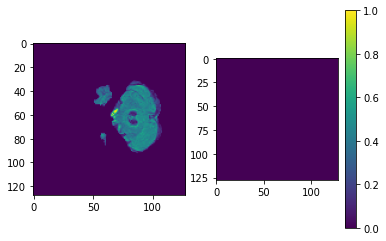

In [ ]:
# Print a sample slice and the corresponding mask
print(f)
print(f.keys())
image = f['image']
mask = f['mask']
img_data = np.array(image[0,:,:,0])
mask_data = np.array(mask[0,:,:,2])
fig, axarr = plt.subplots(1,2)
brain = axarr[0].imshow(img_data[:,:])
fig.colorbar(brain)
tumor = axarr[1].imshow(mask_data[:,:])

In [ ]:
f.close()

In [ ]:
data_dir = "/content/drive/MyDrive/MBP 1413 - Group Project/Data/sets/"
filenames = os.listdir(data_dir)
print(filenames)
f_train = h5py.File(os.path.join(data_dir,'train.h5')) #selects the training set
f_val = h5py.File(os.path.join(data_dir,'val.h5')) #selects the val set

['train.h5', 'val.h5', 'test.h5', 'preprocessing.ipynb']


U-Net Creation

In [ ]:
# Create function for the encoding/down convolutional layers
def EncoderBlk(input,filters=32,dropout=0.5,max_pooling=True):
  layer = tf.keras.layers.Conv2D(filters,3,activation='relu',padding='same')(input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.Conv2D(filters,3,activation='relu',padding='same')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.Dropout(dropout)(layer)
  skip = layer
  if max_pooling:
    layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(layer)
  
  return layer, skip

In [ ]:
# Create function for the decoding/up convolutional layers, including concatenation with earlier blocks
def DecoderBlk(layer_input,skip_input,filters=32):
  layer = tf.keras.layers.Conv2DTranspose(filters,(3,3),strides=(2,2),padding='same')(layer_input)
  skip = tf.keras.layers.concatenate([layer,skip_input],axis=3)
  layer = tf.keras.layers.Conv2D(filters,3,activation='relu',padding='same')(skip)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.Conv2D(filters,3,activation='relu',padding='same')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)

  return layer

In [ ]:
# Create function to create U-Net architecture by using encoding and decoding blocks
def UNetArch(input_size=(128,128,4),filters=32,dropout=0.5,classes=3): 
  # Get first layer to take in images
  inputs = tf.keras.layers.Input(shape=input_size)

  # Start going down the U-shape with encoding blocks
  down_blk1 = EncoderBlk(inputs,filters,dropout,max_pooling=True)
  down_blk2 = EncoderBlk(down_blk1[0],filters*2,dropout,max_pooling=True)
  down_blk3 = EncoderBlk(down_blk2[0],filters*4,dropout,max_pooling=True)
  down_blk4 = EncoderBlk(down_blk3[0],filters*8,dropout,max_pooling=True)
  down_blk5 = EncoderBlk(down_blk4[0],filters*16,dropout,max_pooling=False)

  # Start going up the U-shape with decoding blocks
  up_blk6 = DecoderBlk(down_blk5[0],down_blk4[1],filters*8)
  up_blk7 = DecoderBlk(up_blk6,down_blk3[1],filters*4)
  up_blk8 = DecoderBlk(up_blk7,down_blk2[1],filters*2)
  up_blk9 = DecoderBlk(up_blk8,down_blk1[1],filters)

  # Final layer for output of classes (for different tumour sections)
  layer = tf.keras.layers.Conv2D(classes,1,activation='sigmoid',padding='same')(up_blk9)  
  
  model = tf.keras.Model(inputs=inputs,outputs=layer)

  return model

In [ ]:
unet = UNetArch(input_size=(128,128,4),filters=32,dropout=0.8,classes=3) 
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

Compile and Train the Model

In [ ]:
# Compile the model
unet.compile(
        loss='categorical_crossentropy', 
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6,clipnorm=1.0,clipvalue=0.5))

In [ ]:
checkpoint_path = "/content/drive/MyDrive/MBP 1413 - Group Project/Data/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

# Create a callback to stop training when loss does not decrease sufficiently to avoid overfitting
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.05,patience=2)

In [ ]:
# Line for loading model for secondary training
unet.load_weights("/content/drive/MyDrive/MBP 1413 - Group Project/Data/training_final_saved_model/cp.ckpt")

In [ ]:
# Train the model on the first half of the training and validation data
# Load model after and train on second half (due to RAM restrictions in Colab)

history = unet.fit(
    f_train['image'][:8000,:,:,:], 
    f_train['mask'][:8000,:,:,:],    
    batch_size=2,
    epochs=25,
    verbose=1,
    validation_data=(f_val['image'][:2500,:,:,:],f_val['mask'][:2500,:,:,:]),
    callbacks=[cp_callback,stop_callback])

In [ ]:
# Get information about training
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(15)

In [ ]:
plt.plot(epochs,acc,'bo',label='Training Acc')
plt.plot(epochs,val_acc,'b',label='Validation Acc')
plt.title('Training and Validation Categorical Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'ro',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Evaluate with Test Data

In [ ]:
f_test = h5py.File(os.path.join(data_dir,'test.h5')) #selects the test set

In [ ]:
# Evaluate to see general accuracy
unet.evaluate(x=f_test['image'][:,:,:,:],
              y=f_test['mask'][:,:,:,:],
              batch_size=1,
              verbose=1)

2418/2418 [==============================] - 23s 5ms/step - loss: 0.8568 - categorical_accuracy: 0.8948


[0.8568165898323059, 0.8948148488998413]

In [ ]:
# Create predicted masks for test data
predictions = unet.predict(x=f_test['image'][:,:,:,:],
             batch_size=1,
             verbose=1)

2418/2418 [==============================] - 20s 4ms/step


In [ ]:
# Due to sigmoid activation in final layer, output is continuous between 0 and 1
# For a better visualized mask, round values to 0 and 1 at 0.99 threshold
predictions[predictions[:,:,:,:] < 0.99] = 0
predictions[predictions[:,:,:,:] >= 0.99] = 1

Text(0.5, 1.0, 'MASK: ED')

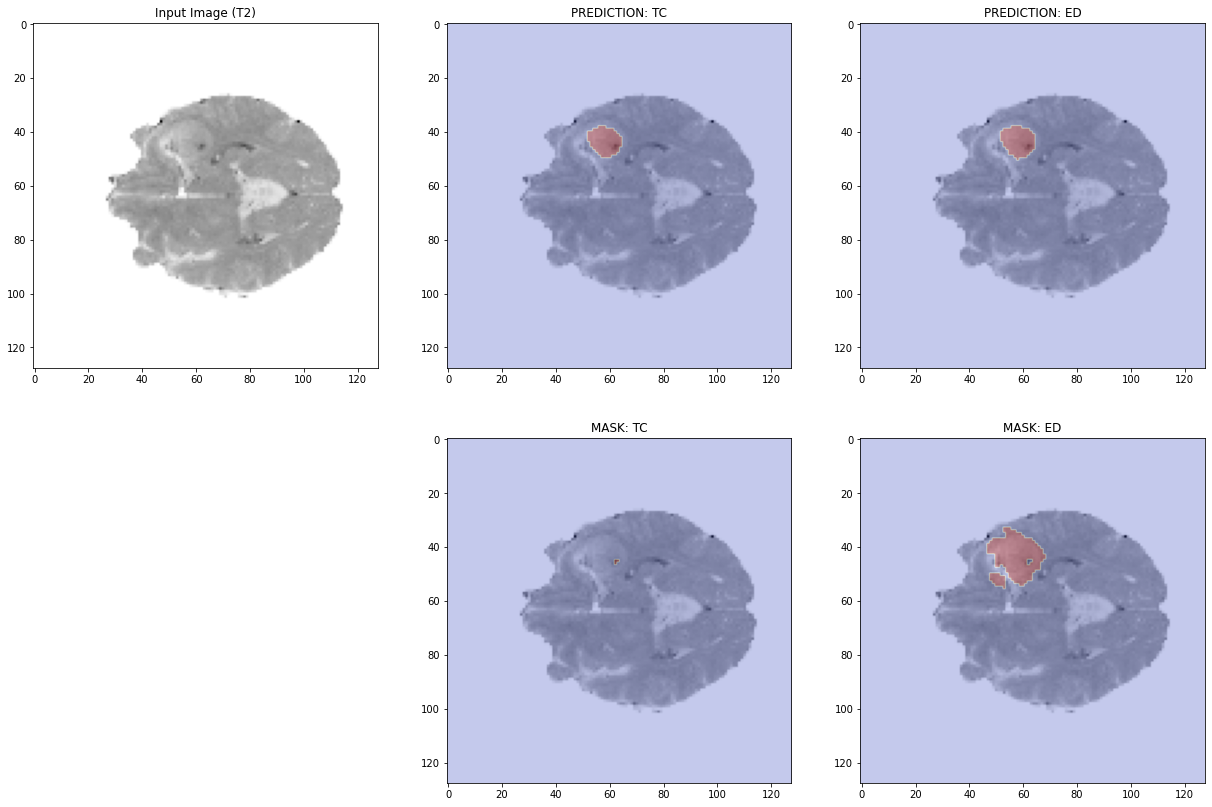

In [ ]:
# Print sample figures comparing predicted and actual mask
p_idx = 2320
m_idx = p_idx

fig, axs = plt.subplots(2, 3, figsize=(21,14))
axs[0,0].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[0,0].set_title('Input Image (T2)')

axs[0,1].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[0,1].imshow(predictions[p_idx,:,:,1], alpha=0.3, cmap='coolwarm')
axs[0,1].set_title('PREDICTION: TC')

axs[0,2].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[0,2].imshow(predictions[p_idx,:,:,2], alpha=0.3, cmap='coolwarm')
axs[0,2].set_title('PREDICTION: ED')

axs[1,0].axis('off')

axs[1,1].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[1,1].imshow(f_test['mask'][m_idx,:,:,1], alpha=0.3, cmap='coolwarm')
axs[1,1].set_title('MASK: TC')

axs[1,2].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[1,2].imshow(f_test['mask'][m_idx,:,:,2], alpha=0.3, cmap='coolwarm')
axs[1,2].set_title('MASK: ED')

In [ ]:
# Calculate Dice Scores:
num_test_samples = np.shape(f_test['mask'][:,:,:,:])[0]

sum_all_dice_coeff_TC = 0
sum_all_dice_coeff_ED = 0

# Lopp through each sample in the test set
for test_sample_idx in range(num_test_samples):
  # Extract ground truth and predicted mask for TC
  test_sample_mask_TC = f_test['mask'][test_sample_idx,:,:,1]
  test_sample_pred_TC = predictions[test_sample_idx,:,:,1]
  # Extract ground truth and predicted mask for ED
  test_sample_mask_ED = f_test['mask'][test_sample_idx,:,:,2]
  test_sample_pred_ED = predictions[test_sample_idx,:,:,2]

  # Count the number of pixels in each: ground truth and predicted masks
  num_mask_TC = sum(sum(test_sample_mask_TC))
  num_pred_TC = sum(sum(test_sample_pred_TC))
  num_mask_ED = sum(sum(test_sample_mask_ED))
  num_pred_ED = sum(sum(test_sample_pred_ED))

  # Count the number of pixels overlapping in ground truth and predicted masks
  num_overlap_TC = sum(sum(test_sample_mask_TC * test_sample_pred_TC))
  num_overlap_ED = sum(sum(test_sample_mask_ED * test_sample_pred_ED))

  # Calculate Dice coefficient
  if (num_mask_TC == 0 and num_pred_TC == 0): #If both masks are empty, manually set dice=1 to avoid division by 0
    dice_coeff_TC = 1
  else:
    dice_coeff_TC = 2*num_overlap_TC / (num_mask_TC+num_pred_TC)
  
  if (num_mask_ED == 0 and num_pred_ED == 0):
    dice_coeff_ED = 1
  else:
    dice_coeff_ED = 2*num_overlap_ED / (num_mask_ED+num_pred_ED)
  
  # Add to total sum of all Dice coefficients
  sum_all_dice_coeff_TC = sum_all_dice_coeff_TC + dice_coeff_TC
  sum_all_dice_coeff_ED = sum_all_dice_coeff_ED + dice_coeff_ED

# Calculate average Dice coefficients
avg_dice_coff_TC = sum_all_dice_coeff_TC / num_test_samples
avg_dice_coff_ED = sum_all_dice_coeff_ED / num_test_samples

print(f"Dice score (TC): {avg_dice_coff_TC}")
print(f"Dice score (ED): {avg_dice_coff_ED}")

Dice score (TC): 0.33313397356383073
Dice score (ED): 0.243348291523049


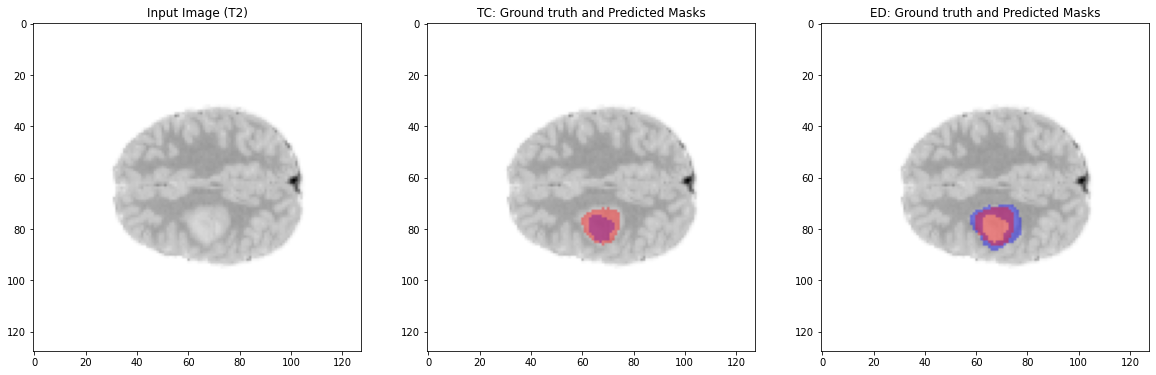

In [ ]:
# Generate sample figure showing what Dice Score represents

test_sample_idx = 98

# Extract ground truth and predicted mask for TC
test_sample_mask_TC = f_test['mask'][test_sample_idx,:,:,1]
test_sample_pred_TC = predictions[test_sample_idx,:,:,1]
# Extract ground truth and predicted mask for ED
test_sample_mask_ED = f_test['mask'][test_sample_idx,:,:,2]
test_sample_pred_ED = predictions[test_sample_idx,:,:,2]

# Create mask of overlapping regions
overlap_TC = test_sample_mask_TC * test_sample_pred_TC
overlap_ED = test_sample_mask_ED * test_sample_pred_ED

# Create custom colormaps that are transparent at values of 0
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)

# Visualize results
fig, axs = plt.subplots(1, 3, figsize=(20,10))
axs[0].imshow(f_test['image'][test_sample_idx,:,:,2], cmap='Greys')
axs[0].set_title('Input Image (T2)')

axs[1].imshow(f_test['image'][test_sample_idx,:,:,2], cmap='Greys')
axs[1].imshow(test_sample_mask_TC, alpha=0.4, cmap=cmapblue)
axs[1].imshow(test_sample_pred_TC, alpha=0.4, cmap=cmapred)
axs[1].set_title('TC: Ground truth and Predicted Masks')

axs[2].imshow(f_test['image'][test_sample_idx,:,:,2], cmap='Greys')
axs[2].imshow(test_sample_mask_ED, alpha=0.4, cmap=cmapblue)
axs[2].imshow(test_sample_pred_ED, alpha=0.4, cmap=cmapred)
axs[2].set_title('ED: Ground truth and Predicted Masks');

In [ ]:
# Estimate uncertainty on 1 sample from the test set, using drop-out during repeated predictions
repleated_preds = np.stack([unet(f_test['image'][10:11,:,:,:],training=True)
                   for sample in range(100)])
certainty = repleated_preds.mean(axis=0)

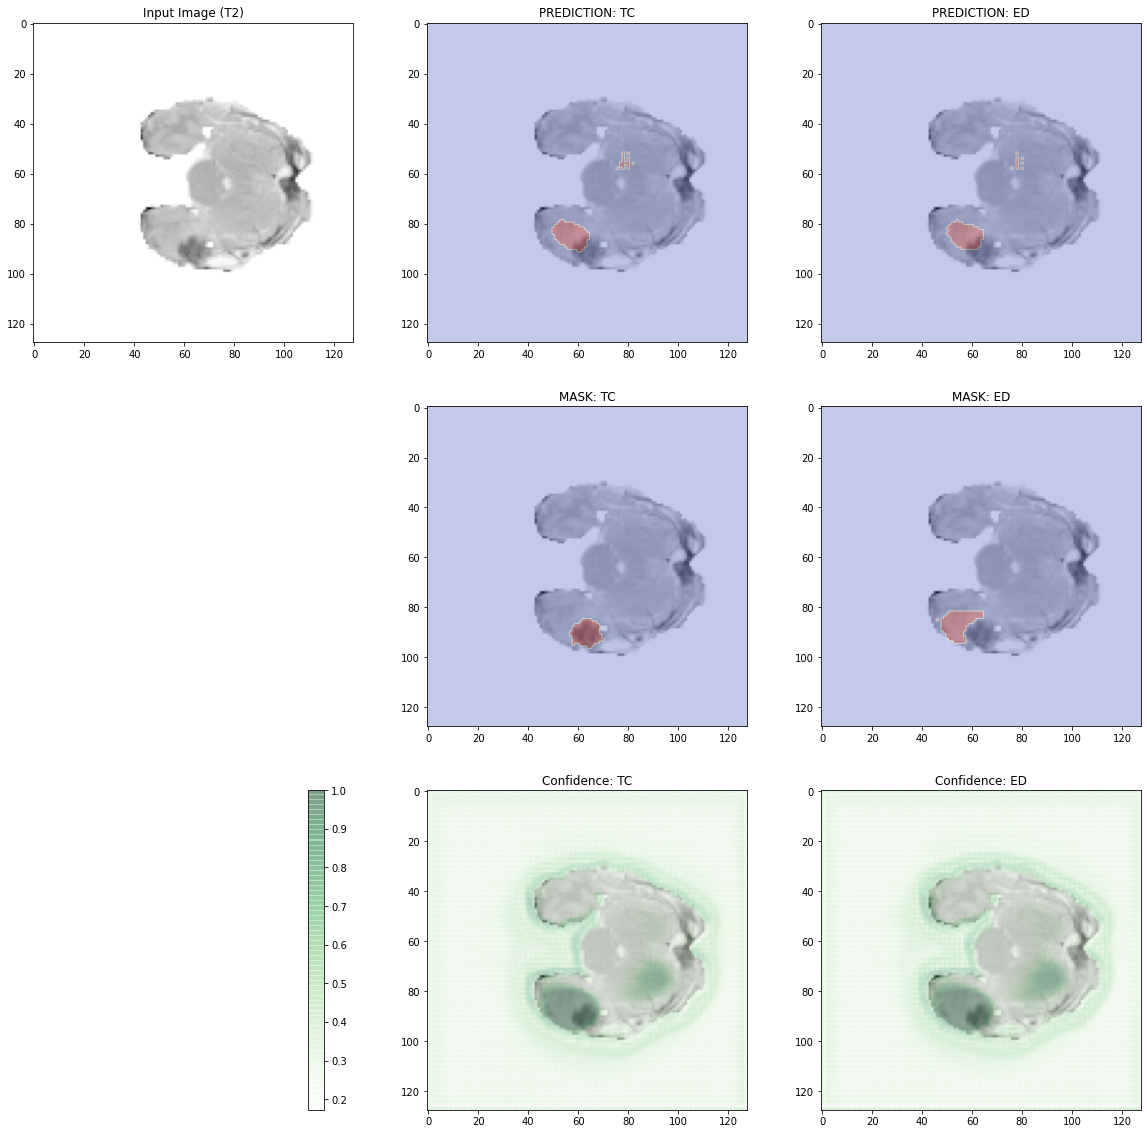

In [ ]:
# Print sample figures comparing predicted and actual mask, with estimated uncertainty
p_idx = 10
m_idx = p_idx

fig, axs = plt.subplots(3, 3, figsize=(20,20))

axs[0,0].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[0,0].set_title('Input Image (T2)')

axs[0,1].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[0,1].imshow(predictions[p_idx,:,:,1], alpha=0.3, cmap='coolwarm')
axs[0,1].set_title('PREDICTION: TC')

axs[0,2].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[0,2].imshow(predictions[p_idx,:,:,2], alpha=0.3, cmap='coolwarm')
axs[0,2].set_title('PREDICTION: ED')

axs[1,0].axis('off')

axs[1,1].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[1,1].imshow(f_test['mask'][m_idx,:,:,1], alpha=0.3, cmap='coolwarm')
axs[1,1].set_title('MASK: TC')

axs[1,2].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[1,2].imshow(f_test['mask'][m_idx,:,:,2], alpha=0.3, cmap='coolwarm')
axs[1,2].set_title('MASK: ED')

axs[2,0].axis('off')

axs[2,1].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
certainty_overlay = axs[2,1].imshow(certainty[0,:,:,1], alpha=0.3, cmap='Greens')
axs[2,1].set_title('Confidence: TC')

axs[2,2].imshow(f_test['image'][p_idx,:,:,2], cmap='Greys')
axs[2,2].imshow(certainty[0,:,:,2], alpha=0.3, cmap='Greens')
axs[2,2].set_title('Confidence: ED')

fig.colorbar(certainty_overlay, ax=axs[2,0])